In [ ]:
# Credits
# https://www.kaggle.com/code/datafan07/top-1-approach-eda-new-models-and-stacking/notebook


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import warnings

pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

In [27]:
# Load the CSV file
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/train.csv')

# Dropping unnecessary Id column.
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Backing up target variables and dropping them from train data.
y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

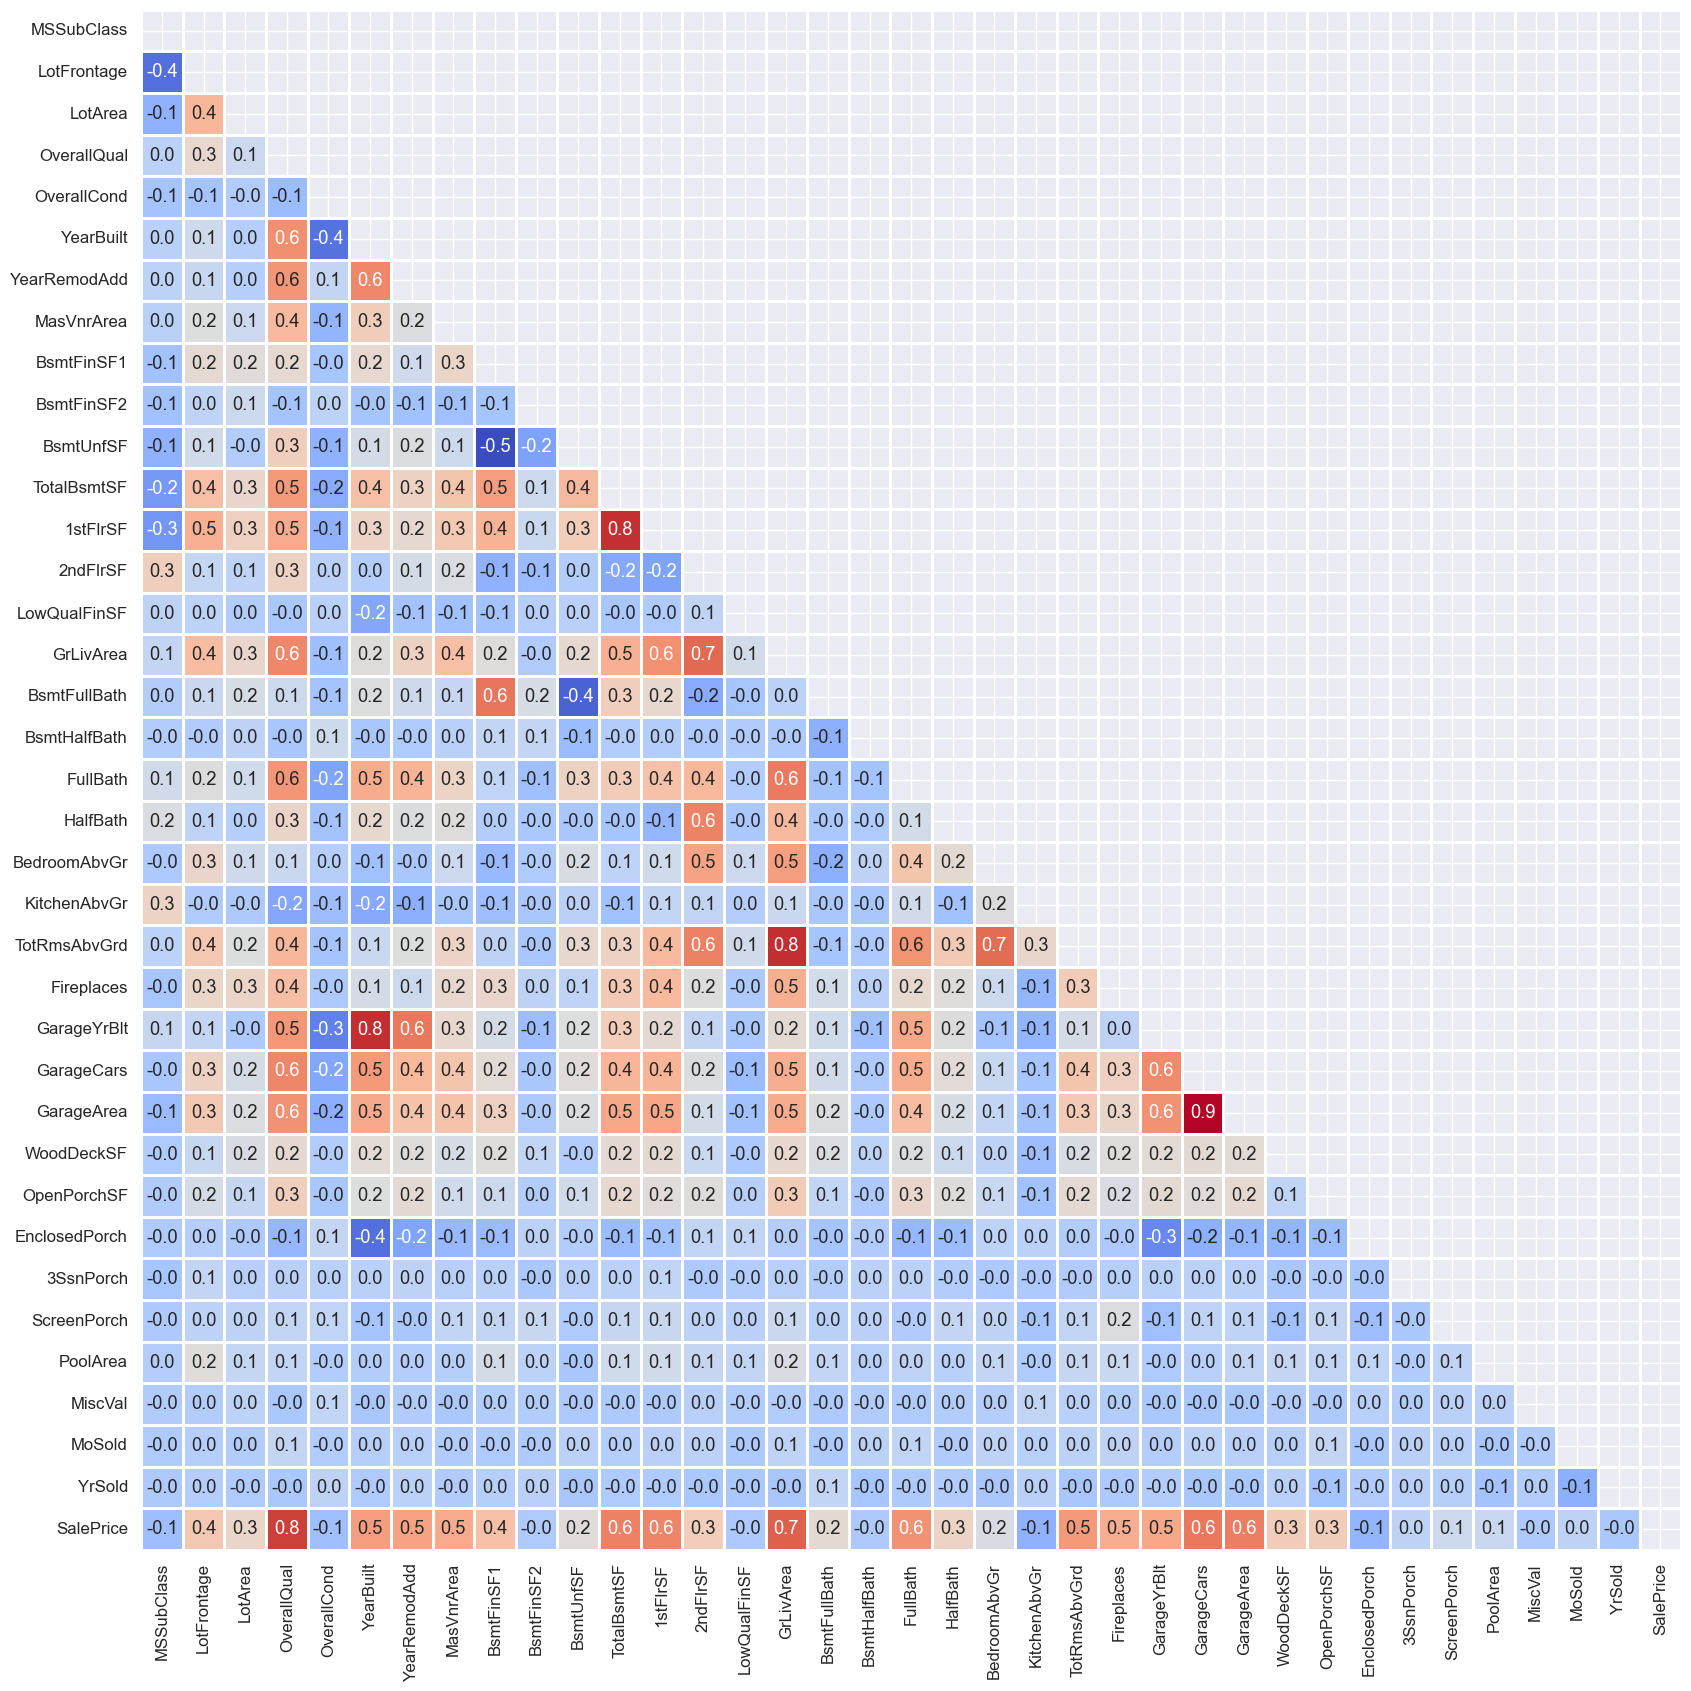

In [28]:
# Display numerical correlations (pearson) between features on heatmap.
sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

In [29]:
# Merging train test features for engineering.
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2920, 80)


In [30]:
def missing_percentage(df):
    
    """A function for returning missing ratios."""
    
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

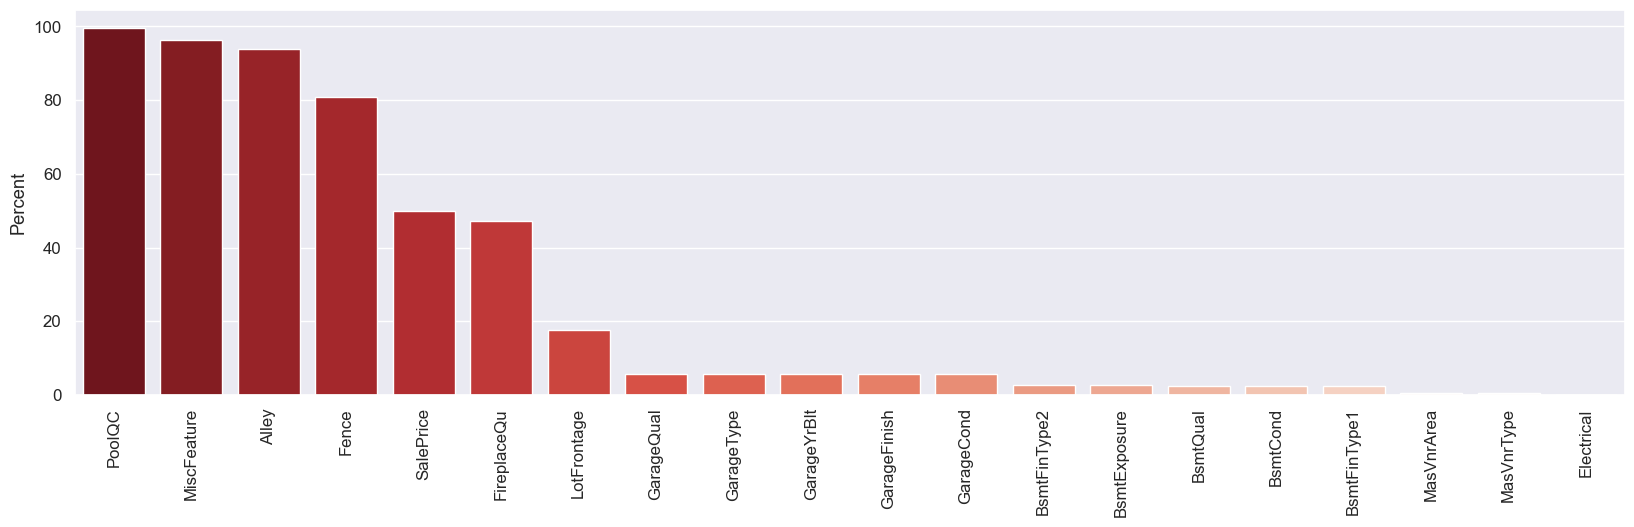

In [31]:
# Checking 'NaN' values.

missing = missing_percentage(features)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

In [32]:
# List of 'NaN' including columns where NaN's mean none.
none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

# List of 'NaN' including columns where NaN's mean 0.
zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

# List of 'NaN' including columns where NaN's actually missing gonna replaced with mode.
freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities'
]

# Filling the list of columns above with appropriate values:
for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)

for col in none_cols:
    features[col].replace(np.nan, 'None', inplace=True)

for col in freq_cols:
    features[col].replace(np.nan, features[col].mode()[0], inplace=True)

In [33]:
# Filling 'MSZoning' according to MSSubClass.
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))

In [34]:
# Filling 'LotFrontage' according to Neighborhood.
features['LotFrontage'] = features.groupby(
    ['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [35]:
# Features which numerical on data but should be treated as category:
features['MSSubClass'] = features['MSSubClass'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [36]:
# Transforming rare values(less than 10) into one group.
others = [
    'Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Heating', 'Electrical', 'Functional', 'SaleType'
]

for col in others:
    mask = features[col].isin(
        features[col].value_counts()[features[col].value_counts() < 10].index)
    features[col][mask] = 'Other'

In [37]:
def srt_box(y, df):
    
    '''A function for displaying categorical variables.'''
    
    fig, axes = plt.subplots(14, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['object']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

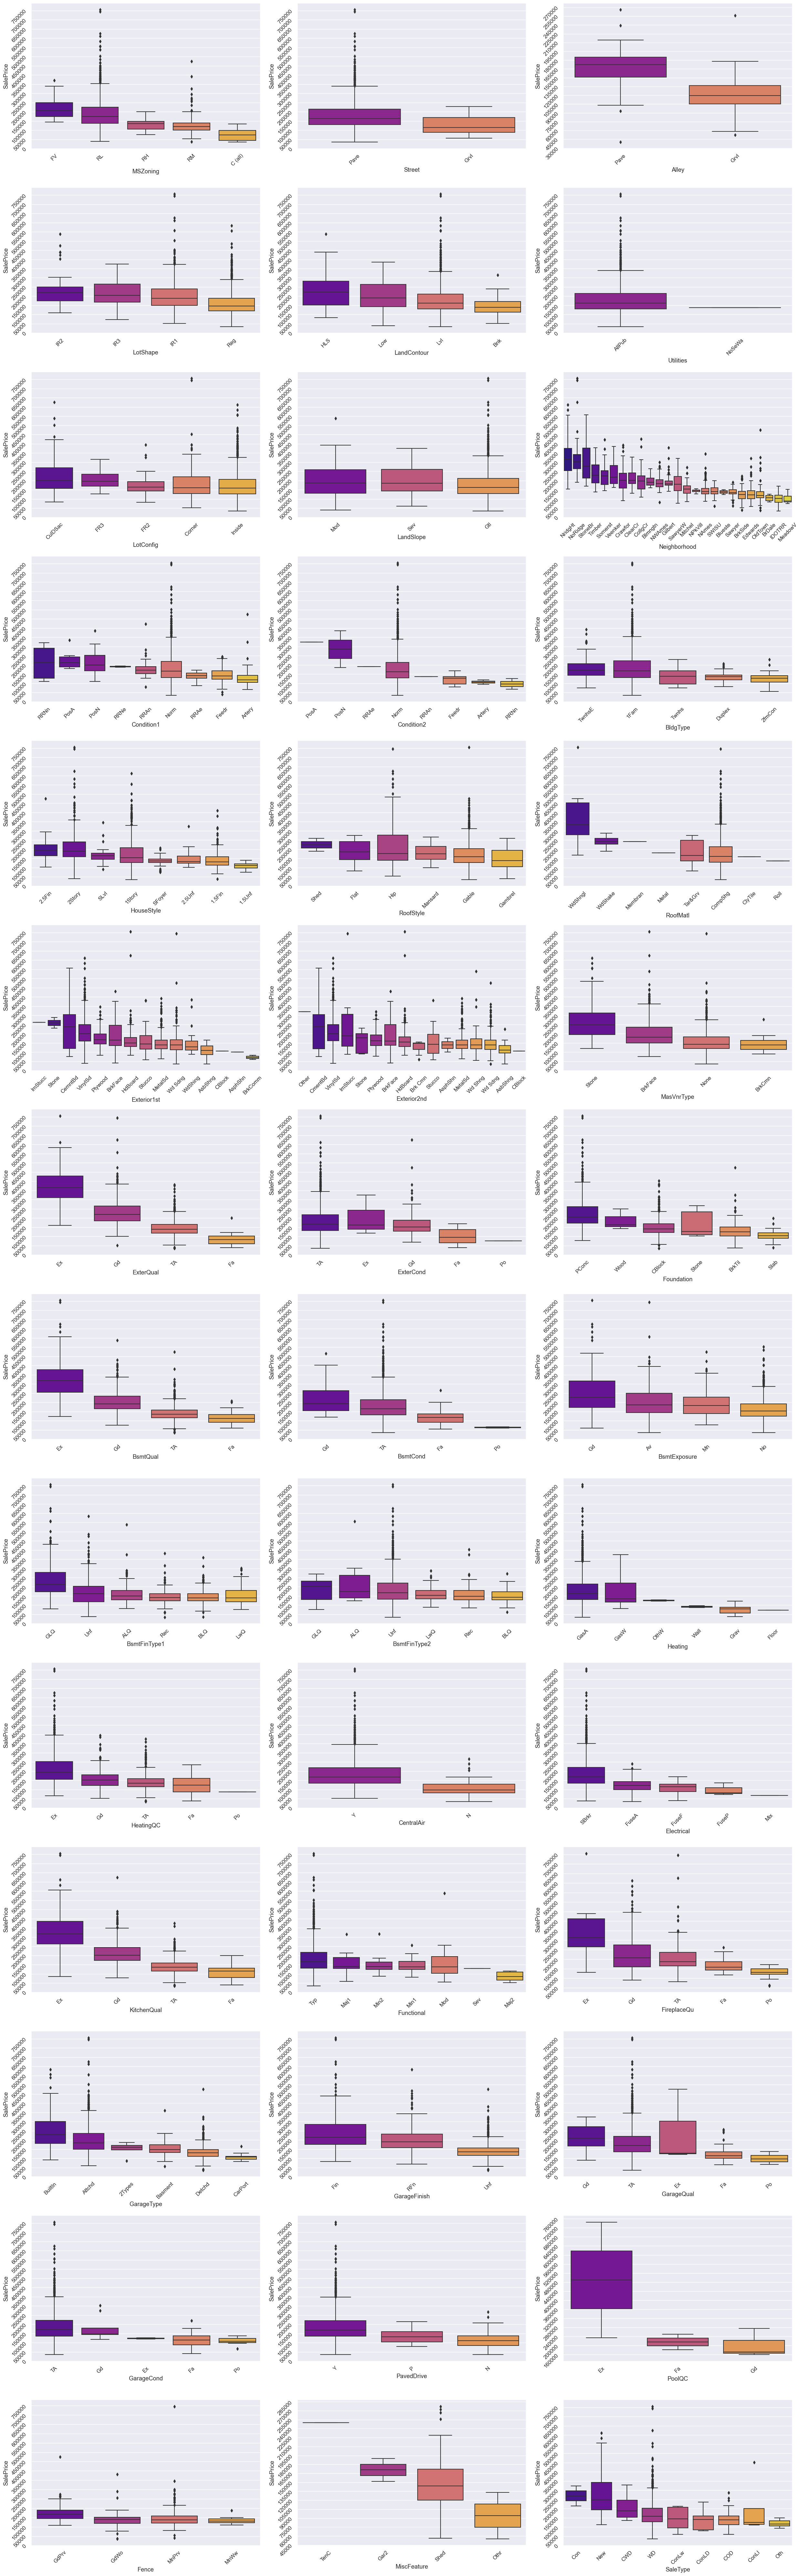

In [38]:
# Displaying sale prices vs. categorical values:
srt_box('SalePrice', train)

In [39]:
# Converting some of the categorical values to numeric ones. Choosing similar values for closer groups to balance linear relations...

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}

features['Neighborhood'] = features['Neighborhood'].map(neigh_map).astype(
    'int')
ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')
features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')

In [40]:
# Plotting numerical features with polynomial order to detect outliers by eye.

def srt_reg(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

In [41]:
srt_reg('SalePrice', train)

In [43]:
features

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0            60       RL         65.0     8450   Pave  None      Reg   
1            20       RL         80.0     9600   Pave  None      Reg   
2            60       RL         68.0    11250   Pave  None      IR1   
3            70       RL         60.0     9550   Pave  None      IR1   
4            60       RL         84.0    14260   Pave  None      IR1   
...         ...      ...          ...      ...    ...   ...      ...   
2915         60       RL         62.0     7917   Pave  None      Reg   
2916         20       RL         85.0    13175   Pave  None      Reg   
2917         70       RL         66.0     9042   Pave  None      Reg   
2918         20       RL         68.0     9717   Pave  None      Reg   
2919         20       RL         75.0     9937   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope  Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl             5       Norm   
1            Lvl    AllPub       FR2       Gtl             7      Feedr   
2            Lvl    AllPub    Inside       Gtl             5       Norm   
3            Lvl    AllPub    Corner       Gtl             6       Norm   
4            Lvl    AllPub       FR2       Gtl            10       Norm   
...          ...       ...       ...       ...           ...        ...   
2915         Lvl    AllPub    Inside       Gtl             5       Norm   
2916         Lvl    AllPub    Inside       Gtl             5       Norm   
2917         Lvl    AllPub    Inside       Gtl             6       Norm   
2918         Lvl    AllPub    Inside       Gtl             3       Norm   
2919         Lvl    AllPub    Inside       Gtl             2       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
2915       Norm     1Fam     2Story            6            5       1999   
2916       Norm     1Fam     1Story            6            6       1978   
2917       Norm     1Fam     2Story            7            9       1941   
2918       Norm     1Fam     1Story            5            6       1950   
2919       Norm     1Fam     1Story            5            6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
2915          2000     Gable  CompShg     VinylSd     VinylSd       None   
2916          1988     Gable  CompShg     Plywood     Plywood      Stone   
2917          2006     Gable  CompShg     CemntBd     CmentBd       None   
2918          1996       Hip  CompShg     MetalSd     MetalSd       None   
2919          1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  \
0          196.0          4          3      PConc         4         3   
1            0.0          3          3     CBlock         4         3   
2          162.0          4          3      PConc         4         3   
3            0.0          3          3     BrkTil         3         4   
4          350.0          4          3      PCon

In [44]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [42]:
# Dropping outliers after detecting them by eye.

features = features.join(y)
features = features.drop(features[(features['OverallQual'] < 5)
                                  & (features['SalePrice'] > 200000)].index)
features = features.drop(features[(features['GrLivArea'] > 4000)
                                  & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['GarageArea'] > 1200)
                                  & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['TotalBsmtSF'] > 3000)
                                  & (features['SalePrice'] > 320000)].index)
features = features.drop(features[(features['1stFlrSF'] < 3000)
                                  & (features['SalePrice'] > 600000)].index)
features = features.drop(features[(features['1stFlrSF'] > 3000)
                                  & (features['SalePrice'] < 200000)].index)

y = features['SalePrice']
y.dropna(inplace=True)
features.drop(columns='SalePrice', inplace=True)

ValueError: columns overlap but no suffix specified: Index(['SalePrice'], dtype='object')